In [1]:
import sys
sys.path.append('../Nets/')
sys.path.append('../')
from glob import glob
from os.path import join
from multiprocessing import Pool
from scipy.ndimage.interpolation import rotate
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from functools import partial
from Nodule import *
from paths import *
%pylab inline
from NoduleClf import*

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
clf_model, coders = predictor()
clf_model.compile('adam', 'binary_crossentropy')
clf_model.load_weights(join(PATH['WEIGHTS'], '3DCAE_nodule_clf_50'))

In [3]:
def augment_patch(patch, shape, angle=15, shift=4):
    
    center = array(patch.shape) // 2
    
    left = array(shape) // 2
    right = array(shape) - left
    
    patch = [patch[center[0] - left[(0 + i) % 3]:center[0] + right[(0 + i) % 3], 
                  center[1] - left[(1 + i) % 3]:center[1] + right[(1 + i) % 3], 
                  center[2] - left[(2 + i) % 3]:center[2] + right[(2 + i) % 3]] for i in range(3)]

    for i, el in enumerate(patch):
        if i == 1:
            patch[i] = rotate(el, angle=90, axes=(0, 2))
            
        if i == 2:
            patch[i] = rotate(el, angle=90, axes=(0, 1))
            
        mn = el.min()
        mx = el.max()
        if (mx - mn) != 0:
            patch[i] = (patch[i] - mn) / (mx - mn)
        else:
            patch[i][:, :, :] = 0
            
    
    return patch

In [70]:
def extract_patches(lung_path, mask_path, stride=(8, 8, 8), shape=(64, 64, 64)):
    lung = load(lung_path)
    mask = load(mask_path)
    number_of_slices = ceil((asarray(lung.shape) - asarray(shape)) 
                            / asarray(stride)).astype(int)

    center = array(shape) // 2
    patches = list()
    coords = list()
    for i in range(number_of_slices[0]):
        for j in range(number_of_slices[1]):
            for k in range(number_of_slices[2]):
                diff = mask[i * stride[0]: i * stride[0] + shape[0], 
                            j * stride[1]: j * stride[1] + shape[1], 
                            k * stride[2]: k * stride[2] + shape[2]]
                
                if diff[center[0] - stride[0]:center[0] + stride[0], 
                        center[1] - stride[1]:center[1] + stride[1], 
                        center[2] - stride[2]:center[2] + stride[2]].sum() < 20:
                    continue
                
                patch = lung[i * stride[0]: i * stride[0] + shape[0], 
                             j * stride[1]: j * stride[1] + shape[1], 
                             k * stride[2]: k * stride[2] + shape[2]]
                
                if patch.shape != shape:
                    continue
                if  not patch[center[0] - stride[0]:center[0] + stride[0], 
                              center[1] - stride[1]:center[1] + stride[1], 
                              center[2] - stride[2]:center[2] + stride[2]].sum():
                    continue
                patches.append(patch)
                coords.append((i, j, k))
    return patches, coords

In [71]:
def batch_generator(patches, batch_size, 
                    shape=(8, 64, 64), 
                    CPU=4, projections=3):
    
    
    number_of_batches = ceil(len(patches) / batch_size)
    counter = 0
    
    while counter < number_of_batches:
        batch = patches[batch_size * counter: batch_size * (counter + 1)]        
        
        augment = partial(augment_patch, shape=shape)
        
        with Pool(CPU) as pool:
            patch_list = pool.map(augment, batch)
            
        counter += 1
        patch_list = [expand_dims(array([patch[i]
                       for patch in patch_list]), 1)  
                      for i in range(projections)]
        
        yield patch_list

In [73]:
lung_path = '../../../data/TRAIN_OUT/LUNGS_IMG/0015ceb851d7251b8f399e39779d1e7dlungs_right.npy'
mask_path = '../../../data/TRAIN_OUT/MASKS/0015ceb851d7251b8f399e39779d1e7ddiff_right.npy'

batch_size = 32

patches, coords = extract_patches(lung_path, mask_path) 
generator = batch_generator(patches, batch_size)

In [74]:
len(patches)

3571

In [75]:
nb_iterations = int(ceil(len(patches) / batch_size))
predicted = list()
coordinate = list()

for i in tqdm(range(nb_iterations)):
    predicted += clf_model.predict(next(generator)).reshape(-1).tolist()
    coordinate += coords[batch_size * i: batch_size * (i + 1)]


  0%|          | 0/112 [00:00<?, ?it/s]




100%|██████████| 112/112 [12:37<00:00,  6.33s/it]


In [88]:
x_min, y_min, z_min = (asarray(coordinate)[:, 0].min(), asarray(coordinate)[:, 1].min(), asarray(coordinate)[:, 2].min())
x_max, y_max, z_max = (asarray(coordinate)[:, 0].max(), asarray(coordinate)[:, 1].max(), asarray(coordinate)[:, 2].max())

In [89]:
x_min, y_min, z_min

(4, 1, 5)

In [83]:
mask = load(mask_path)
lung = load(lung_path)
pred = zeros(asarray(mask.shape) // 8)
for coord, val in zip(coordinate, predicted):
    pred[coord] = val

In [87]:
where(pred == pred.max())

(array([ 6,  7,  7, 12, 12, 12, 12, 13, 13, 13, 13, 15, 20, 20, 21, 41, 47]),
 array([28, 28, 28,  4,  4,  5, 30,  4,  4,  5,  5,  6,  5,  6,  6,  7, 13]),
 array([22, 21, 22, 21, 22, 21, 20, 21, 22, 21, 22, 22, 21, 21, 21, 13, 12]))

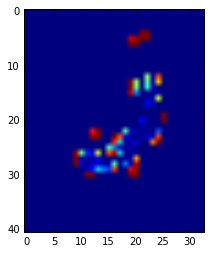

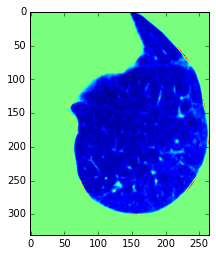

In [92]:
imshow(pred[12])
show()
imshow(lung[12 * 8 + 3 * 8])
show()